# Deep learning 

 
In this step, similarly to step 3, data from the dataset for multivariate classification will be used to develop Deep Learning (DL) models to predict subclasses of transferases (class 2). 

The Deep Learning model development methods used come from the package tensorflow. keras. Where training, testing and validation data are introduced. 

In the development of deep learning models, methods verified in the literature that aim to classify enzymes were used. 
These methods are:
- DNN – “Dense Neural Networks” is a model of supervised deep learning that consists of “feedforward” neural networks, this method being one of the simplest of deep learning.

### Imports

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

import warnings
warnings.filterwarnings("ignore")

## Family descriptors with dense neural networks (DNN)

Proteins are generally composed of one or more functional regions, commonly termed domains. Different combinations of domains give rise to the diverse range of proteins found in nature. The identification of domains that occur within proteins can therefore provide insights into their function.

- Pfam: protein domain database UniProtKB. Widely used database of protein families, each represented by multiple sequence alignments and hidden Markov models (HMMs).

These descriptors are still dependent of similarities between sequences.

Goal:

- Generate features based with Pfam

Workflow: 

- Binarize PFAM domains 
- Binarize multiclass labels
- Apply DNN 

### Dataset upload

**data_feature_x_new** - dataset we obtained after doing the feature selection in the preprocessing 

**data_feature_y** - dataset containing the class 'ec_lev'

**data_new** - original dataset with only data from class 2

In [5]:
data_feature_x_new = pd.read_csv('data_feature_x_new.csv')
data_feature_y = pd.read_csv('data_feature_y.csv')
data_new = pd.read_csv('data_new.csv')

In [6]:
data_new

,level_0,index,uniref_90,Entry,Protein names,ec_number,sequence,pfam,supfam,go,ec_lev
0,36250,109011,P0CN83,P0CN83,"1,4-alpha-glucan-branching enzyme (EC 2.4.1.18...",2.4.1.18,MTAVSLSDGTAVLKTDPWLEPFSGALRERYAAYQKQRTIIEEHEGG...,PF00128;PF02806;PF02922;,SSF51445;SSF81296;,GO:0003844; GO:0004553; GO:0005978; GO:0043169...,4
1,36790,110453,A5VXJ2,A5VXJ2,Thiosulfate sulfurtransferase GlpE (EC 2.8.1.1),2.8.1.1,MSEFKRIPPEQALELRKKEGAVVVDIRDPQAFAAGHITGARHLDNH...,PF00581;,SSF52821;,GO:0004792; GO:0005737; GO:0006071,8
2,31656,89041,A9HKH7,A9HKH7,Protoheme IX farnesyltransferase (EC 2.5.1.141...,2.5.1.141,MSGAATTEGAVTRFDAALVGTEARDWFALLKPRVISLVVFTGAAGL...,PF01040;,NaN,GO:0005886; GO:0008495; GO:0016021; GO:0048034,5
3,37795,112939,B4RV95,B4RV95,Serine hydroxymethyltransferase (SHMT) (Serine...,2.1.2.1,MFSREMNIADFDPELANAMANEVERQEHHIELIASENYCSPRVMEA...,PF00464;,SSF53383;,GO:0004372; GO:0005737; GO:0019264; GO:0030170...,1
4,4335,12074,Q55848,Q55848,Ribose-phosphate pyrophosphokinase (RPPK) (EC ...,2.7.6.1,MSAVSRIATLTRQSMLSALSDNNRLRLFSGSSNPSLSQEVARYLGM...,PF14572;PF13793;,SSF53271;,GO:0000287; GO:0002189; GO:0004749; GO:0005524...,7
...,...,...,...,...,...,...,...,...,...,...,...
13399,19070,54601,A6WWW9,A6WWW9,tRNA (guanine-N(7)-)-methyltransferase (EC 2.1...,2.1.1.33,MTEESHPLRGAGNFFGRRHGKPLRSHQKNLFEDLLPRLKINVENPA...,PF02390;,SSF53335;,GO:0008176,1
13400,28665,82072,Q16880,Q16880,2-hydroxyacylsphingosine 1-beta-galactosyltran...,2.4.1.47,MKSYTPYFILLWSAVGIAKAAKIIIVPPIMFESHMYIFKTLASALH...,PF00201;,NaN,GO:0002175; GO:0003851; GO:0005886; GO:0006682...,4
13401,17995,52095,B0TS89,B0TS89,Thiazole synthase (EC 2.8.1.10),2.8.1.10,MLTIAQHQFESRLFTGTGKFAASEIMLTAIQASQSQLVTLAIKRLD...,PF05690;,NaN,GO:0005737; GO:0009228; GO:0009229; GO:0016783,8
13402,37224,111378,Q72CT0,Q72CT0,Serine hydroxymethyltransferase (SHMT) (Serine...,2.1.2.1,MDELLLQDPEVGKAIILEIERQTGKLELIASENFVSAAVRQAQGSV...,PF00464;,SSF53383;,GO:0004372; GO:0005737; GO:0019264; GO:0030170...,1


Get the PFAM domains from the dataset. 

In [7]:
fam = data_new['pfam']  
fam

0        PF00128;PF02806;PF02922;
1                        PF00581;
2                        PF01040;
3                        PF00464;
4                PF14572;PF13793;
                   ...           
13399                    PF02390;
13400                    PF00201;
13401                    PF05690;
13402                    PF00464;
13403            PF06968;PF04055;
Name: pfam, Length: 13404, dtype: object

Binarize fam domains.

In [8]:
from sklearn.preprocessing._label import MultiLabelBinarizer

fam = [i.split(';') for i in data_new['pfam']] # split 2 Pfam 
fam = [list(filter(None, x)) for x in fam]  # remove '' empty string (because last ;)

# hot encoding vector of Pfam domains
mlb = MultiLabelBinarizer()
fam_ho = mlb.fit_transform(fam)
classes = mlb.classes_
print(classes)
print('number classes', len(classes))
print(fam_ho.shape)
print(fam_ho)

['PF00009' 'PF00010' 'PF00013' ... 'PF18706' 'PF18755' 'PF18836']
number classes 1141
(13404, 1141)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Binarize labels.

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
y=data_new['ec_lev'].astype(str)

mlb = MultiLabelBinarizer()
y_new = mlb.fit_transform(y)
print(mlb.classes_)
print(y_new)

['1' '3' '4' '5' '6' '7' '8']
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


Data division in train and test was performed using the **train_test_split** method of the sklearn package. The division of the dataset was made using 70% for the training phase and 30% for the test phase, with a random_state of 32. After dividing between training and testing, 30% of the training dataset was extracted to be used as a validation dataset.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fam_ho, y_new, test_size = 0.3, random_state = 32, stratify = y)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382, 1141) (9382, 7)
Test:  (4022, 1141) (4022, 7)


GridSearch to optimize the hyperparameters.

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

model = Pipeline([
                  ('scaler',StandardScaler()),
                  ('model',MLPClassifier(random_state = 0))])

search = GridSearchCV(model,
                      {'model__hidden_layer_sizes':[(x,) for x in np.arange(5, 100, 2)]},
                      cv = 5, scoring = "accuracy", verbose = 3, n_jobs = -1)

Train the model with the best parameters obtained from the gridsearch.

In [12]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        MLPClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__hidden_layer_sizes': [(5,), (7,), (9,), (11,),
                                                       (13,), (15,), (17,),
                                                       (19,), (21,), (23,),
                                                       (25,), (27,), (29,),
                                                       (31,), (33,), (35,),
                                                       (37,), (39,), (41,),
                                                       (43,), (45,), (47,),
                                                       (49,), (51,), (53,),
                                                       (55,), (57,), (59,),
                                                       (61,), (63,), ...]},
             scoring='accuracy', verbose=3)

In [54]:
print('Best score:', search.best_score_)

Best score: 0.9601360538808356


In [55]:
print('Best number of hidden layers:', search.best_params_)

Best number of hidden layers: {'model__hidden_layer_sizes': (71,)}


DNN implementation, where the final activation is a softmax layer since our problem is a multiclass classification. Therefore, the predicted values (the final output) will be 7 classes, since the class 2 has seven different subclasses.

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

def dnn(input_shape, optimizer = 'Adam'):   
    l1 = 1e-5
    l2 = 1e-4

    # create model
    
    model = Sequential()
    model.add(Input(shape = (input_shape, )))
    model.add(Dense(71, activation = "relu"))  
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 
    model.add(Dense(36, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  
    model.add(Dense(7, activation = 'softmax'))  
    return model


The parameters for the development of the DL models were adjusted according to the classification problem (number of epochs, batch_size, among others). In this step, the parameter for “EarlyStopping” was also used, a process that aims to interrupt the training of the models if there is a stabilization in the model evaluation results.

In [16]:
model = dnn(input_shape = X_train.shape[1], optimizer = 'Adam')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1) 

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.00001, verbose = 1) 

callbacks = [es, reduce_lr]
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Train model.

In [17]:
history = model.fit(X_train, y_train, epochs = 35, batch_size = 36, callbacks = callbacks, 
                        validation_split = 0.3)

Epoch 1/35
183/183 [==============================] - 5s 9ms/step - loss: 1.1490 - accuracy: 0.6204 - val_loss: 1.6809 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 2/35
183/183 [==============================] - 1s 7ms/step - loss: 0.3985 - accuracy: 0.8961 - val_loss: 0.9262 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 3/35
183/183 [==============================] - 1s 7ms/step - loss: 0.2181 - accuracy: 0.9430 - val_loss: 0.2309 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 4/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1625 - accuracy: 0.9557 - val_loss: 0.1194 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 5/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1328 - accuracy: 0.9628 - val_loss: 0.1116 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 6/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1190 - accuracy: 0.9651 - val_loss: 0.1111 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 7/35
183/183 [==============================] - 1s 7ms/step - lo

In [18]:
tensorflow.keras.backend.clear_session()

Summary of the results obtained.

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 71)                81082     
                                                                 
 batch_normalization (BatchN  (None, 71)               284       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 71)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2592      
                                                                 
 batch_normalization_1 (Batc  (None, 36)               144       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 36)                0

In [20]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.9489076024010068
Validation Accuracy:  0.9251797270207178
Training Loss:  0.1654350342495101
Validation Loss:  0.22901502464498794


Plot accuracy and loss during training.

In [21]:
def plot_summary_accuracy(model, path_save = None, show = True):
    """
    Function to plot training and validation accuracy
    """
    plt.clf()

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    if path_save is not None:
        plt.savefig(fname = path_save)
    if show is True:
        plt.show(block = True)
    plt.clf()


def plot_summary_loss(model, path_save = None, show = True):
    """
    Function to plot validationa nd training loss
    """
    dnn = model

    # summarize history for loss
    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    if path_save is not None:
        plt.savefig(fname = path_save)
    if show is True:
        plt.show(block = True)
    plt.clf()


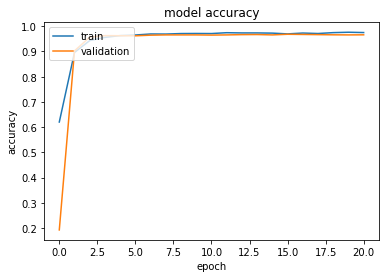

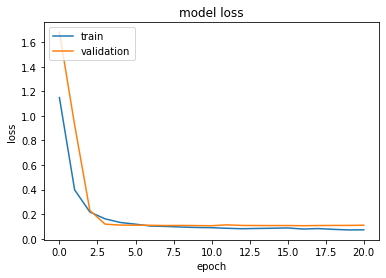

<Figure size 432x288 with 0 Axes>

In [22]:
plot_summary_accuracy(model)
plot_summary_loss(model)

Function to evaluate the model (multiclass problem) with the enumerous metrics to be used.

In [23]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, matthews_corrcoef, classification_report, \
    multilabel_confusion_matrix, roc_auc_score, precision_score,recall_score

def model_evaluate(x_test=None, y_test=None, model=None):
    scores = {}
    cm2 = []
  
    y_prob = model.predict(x_test)
    y_pred= np.argmax(y_prob,axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['MCC'] = matthews_corrcoef(y_test, y_pred)
    scores['log_loss'] = log_loss(y_test, y_prob)

    
    scores['f1 score weighted'] = f1_score(y_test, y_pred, average = 'weighted')
    scores['f1 score macro'] = f1_score(y_test, y_pred, average = 'macro')
    scores['f1 score micro'] = f1_score(y_test, y_pred, average = 'micro')
    scores['roc_auc ovr'] = roc_auc_score(y_test, y_prob, average = 'weighted', multi_class = 'ovr')
    y_test_reshape = y_test.reshape(y_test.shape[0])  
    scores['roc_auc ovo'] = roc_auc_score(y_test_reshape, y_prob, average = 'weighted', multi_class = 'ovo')
    scores['precision'] = precision_score(y_test, y_pred, average = 'weighted')
    scores['recall'] = recall_score(y_test, y_pred, average = 'weighted')
    cm2 = multilabel_confusion_matrix(y_test, y_pred)
    
    return scores, cm2

In [24]:
scores, cm2 = model_evaluate(X_test, y_test, model=model)

126/126 [==============================] - 1s 3ms/step


In [56]:
print('Scores:', scores)

Scores: {'Accuracy': 0.9636996519144704, 'MCC': 0.9578340727811037, 'log_loss': 0.11440359978796893, 'f1 score weighted': 0.9637173809005386, 'f1 score macro': 0.9629744834870578, 'f1 score micro': 0.9636996519144703, 'roc_auc ovr': 0.9986482406540637, 'roc_auc ovo': 0.9985737903746353, 'precision': 0.9652933895604059, 'recall': 0.9636996519144704}


In [59]:
print('Multiple layers of the confusion matrix:\n', cm2)

Multiple layers of the confusion matrix:
 [[[3377   45]
  [  16  584]]

 [[3411   11]
  [  37  563]]

 [[3409   13]
  [  14  586]]

 [[3416    6]
  [   4  596]]

 [[3552   48]
  [   0  422]]

 [[3401   21]
  [  17  583]]

 [[3420    2]
  [  58  542]]]
